# Importing libraries

In [1]:
# !pip install cufflinks
# !pip install colorama
# !pip install pydicom
# !pip install chart_studio
# !pip install pandas_profiling

import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import tqdm
from typing import Dict
import matplotlib.pyplot as plt
%matplotlib inline

#plotly
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

#color
from colorama import Fore, Back, Style

import seaborn as sns
sns.set(style="whitegrid")

#pydicom
import pydicom

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()

# Read data

In [2]:
IMAGE_PATH = "../input/osic-pulmonary-fibrosis-progression/"
list(os.listdir("../input/osic-pulmonary-fibrosis-progression/"))

['.DS_Store',
 'test',
 'test.csv',
 'train',
 'train.csv',
 'sample_submission.csv']

In [3]:
df_train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
df_test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

print(Fore.YELLOW + 'Training data shape: ',Style.RESET_ALL,df_train.shape)
df_train.head(5)

Training data shape:   (1549, 7)


Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker

In [4]:
df_train.groupby(['SmokingStatus']).count()['Sex'].to_frame()

Sex
SmokingStatus         
Currently smokes    82
Ex-smoker         1038
Never smoked       429

# Basic EDA

## Null values and data types

In [5]:
# Null values and Data types
print(Fore.YELLOW + 'Train Set !!',Style.RESET_ALL)
print(df_train.info())
print('-------------')
print(Fore.BLUE + 'Test Set !!',Style.RESET_ALL)
print(df_test.info())

print(f"\n\n## Train missing value count:\n{df_train.isnull().sum()}")
print(f"\n## Test missing value count:\n{df_test.isnull().sum()}")

Train Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB
None
-------------
Test Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        5 non-null      object 
 1   Weeks          5 non-null      int64  
 2   FVC            5 non-null      int64  
 3   Percent        5 non-null      float64
 4   Age            5 non

## N, Unique Patients - Train and Test

In [6]:
print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,df_train['Patient'].count())
print(Fore.BLUE +"Total Patients in Test set: ",Style.RESET_ALL,df_test['Patient'].count())
print(Fore.YELLOW + "The total patient ids are",Style.RESET_ALL,f"{df_train['Patient'].count()},", Fore.BLUE + "from those the unique ids are", Style.RESET_ALL, f"{df_train['Patient'].value_counts().shape[0]}.")

Total Patients in Train set:   1549
Total Patients in Test set:   5
The total patient ids are  1549, from those the unique ids are  176.


## Common Patients

In [7]:
train_patient_ids = set(df_train['Patient'].unique())
test_patient_ids = set(df_test['Patient'].unique())

train_patient_ids.intersection(test_patient_ids)
# 5 patients in test set that can be found in train set as well

{'ID00419637202311204720264',
 'ID00421637202311550012437',
 'ID00422637202311677017371',
 'ID00423637202312137826377',
 'ID00426637202313170790466'}

## Patient counts

- In train, multiple rows for one patient. Because Patient has different weeks, FVC, Percent

In [8]:
print(f"Train - Max Row for one Patient - {df_train['Patient'].value_counts().max()}")
print(f"Test - Max Row for one Patient - {df_test['Patient'].value_counts().max()}")


Train - Max Row for one Patient - 10
Test - Max Row for one Patient - 1


## Number of Patients and Images in training image folder

In [9]:
files = folders = 0

path = "../input/osic-pulmonary-fibrosis-progression/train/"
exclude_prefixes = ["."]
for _, dirnames, filenames in os.walk(path):
    if '.DS_Store' in dirnames:
            dirnames.remove('.DS_Store')
    if '.DS_Store' in filenames:
        filenames.remove('.DS_Store')
    files += len(filenames)
    folders += len(dirnames)
print(Fore.YELLOW +f'{files:,}',Style.RESET_ALL,"files/images, " \
      + Fore.BLUE + f'{folders:,}',Style.RESET_ALL ,'folders/patients')

files = []
for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    if '.DS_Store' in filenames:
        filenames.remove('.DS_Store')
    files.append(len(filenames))

print(Fore.YELLOW +f'{round(np.mean(files)):,}',Style.RESET_ALL,'average files/images per patient')
print(Fore.BLUE +f'{round(np.max(files)):,}',Style.RESET_ALL, 'max files/images per patient')
print(Fore.GREEN +f'{round(np.min(files)):,}',Style.RESET_ALL,'min files/images per patient')

33,026  files/images, 176  folders/patients
187  average files/images per patient
1,018  max files/images per patient
0  min files/images per patient


# Data Exploration in detail

In [10]:
columns = df_train.columns
print(columns)

Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus'], dtype='object')


## Create individual patient dataframes

In [11]:
patient_df = df_train[['Patient', 'Age', 'Sex', 'SmokingStatus']].drop_duplicates().reset_index(drop=True)

# Create unique patient lists and properties
train_dir = "../input/osic-pulmonary-fibrosis-progression/train/"

patients_ids = os.listdir(train_dir)
if '.DS_Store' in patients_ids:
    patients_ids.remove('.DS_Store')
patients_ids = sorted(patients_ids)
no_of_instances = []

for patience_id in patients_ids:
    no_of_instances.append(len(os.listdir(train_dir + patience_id)))

patient_df_tmp = pd.DataFrame(list(zip(patients_ids, no_of_instances)), columns = ['Patient', 'no_of_instances'])
patient_df = pd.merge(patient_df_tmp, patient_df, how="inner", on="Patient")
patient_df

Patient  no_of_instances  Age   Sex SmokingStatus
0    ID00007637202177411956430               30   79  Male     Ex-smoker
1    ID00009637202177434476278              394   69  Male     Ex-smoker
2    ID00010637202177584971671              106   60  Male     Ex-smoker
3    ID00011637202177653955184               31   72  Male     Ex-smoker
4    ID00012637202177665765362               49   65  Male  Never smoked
..                         ...              ...  ...   ...           ...
171  ID00419637202311204720264               28   73  Male     Ex-smoker
172  ID00421637202311550012437               62   68  Male     Ex-smoker
173  ID00422637202311677017371              473   73  Male     Ex-smoker
174  ID00423637202312137826377              290   72  Male     Ex-smoker
175  ID00426637202313170790466              408   73  Male  Never smoked

[176 rows x 5 columns]

## Exploring the 'SmokingStatus' column


In [12]:
print(patient_df['SmokingStatus'].value_counts())
patient_df['SmokingStatus'].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='blue',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the SmokingStatus column in the Unique Patient Set')

Ex-smoker           118
Never smoked         49
Currently smokes      9
Name: SmokingStatus, dtype: int64


## Weeks Distribution

In [13]:
df_train['Weeks'].value_counts().iplot(kind='barh',
                                      xTitle='Counts(Weeks)', 
                                      linecolor='black', 
                                      opacity=0.7,
                                      color='#FB8072',
                                      theme='pearl',
                                      bargap=0.2,
                                      gridcolor='white',
                                      title='Distribution of the Weeks in the training set')
df_train['Weeks'].iplot(kind='hist',
                              xTitle='Weeks', 
                              yTitle='Counts',
                              linecolor='black', 
                              opacity=0.7,
                              color='#FB8072',
                              theme='pearl',
                              bargap=0.2,
                              gridcolor='white',
                              title='Distribution of the Weeks in the training set')
print(df_train['Weeks'].describe())

count    1549.000000
mean       31.861846
std        23.247550
min        -5.000000
25%        12.000000
50%        28.000000
75%        47.000000
max       133.000000
Name: Weeks, dtype: float64


## Distribution age over week

In [14]:
fig = px.scatter(df_train, x="Weeks", y="Age", color='Sex')
fig.show()

## FVC - The Forced Vital Capacity

In [15]:
df_train['FVC'].iplot(kind='hist',
                      xTitle='Lung Capacity(ml)', 
                      linecolor='black', 
                      opacity=0.8,
                      color='#FB8072',
                      bargap=0.5,
                      gridcolor='white',
                      title='Distribution of the FVC in the training set')
print(df_train['FVC'].describe())
df_train['FVC'].value_counts()


count    1549.000000
mean     2690.479019
std       832.770959
min       827.000000
25%      2109.000000
50%      2641.000000
75%      3171.000000
max      6399.000000
Name: FVC, dtype: float64


2095    4
2889    4
2474    4
2965    4
2694    4
       ..
3313    1
3661    1
3299    1
5895    1
4096    1
Name: FVC, Length: 1202, dtype: int64

## FVC vs Percent

In [16]:
fig = px.scatter(df_train, x="FVC", y="Percent", color='Age')
fig.show()

## FVC vs Age

In [17]:
fig = px.scatter(df_train, x="FVC", y="Age", color='Sex')
fig.show()
# Males have higher FVC than females irrespective of age

## FVC vs Weeks¶


In [18]:
fig = px.scatter(df_train, x="FVC", y="Weeks", color='SmokingStatus')
fig.show()
# Person never smoked has FVC lower than smoker. Some Ex-smoker have very high FVC.

## One patient analysis

In [19]:
# Pick one patient for FVC vs Weeks
patient = df_train[df_train.Patient == 'ID00228637202259965313869']
fig = px.line(patient, x="Weeks", y="FVC", color='SmokingStatus')
fig.show()


## Percent

In [20]:
df_train['Percent'].iplot(kind='hist',bins=30,color='blue',xTitle='Percent distribution',yTitle='Count')

## Percent vs SmokingStatus In Patient Dataframe¶


In [21]:
df = df_train
fig = px.violin(df, y='Percent', x='SmokingStatus', box=True, color='Sex', points="all",
          hover_data=df_train.columns)
fig.show()

## Age vs SmokingStatus In Patient Dataframe¶


In [22]:
fig = px.scatter(df_train, x="Age", y="Percent", color='SmokingStatus')
fig.show()

# Data Exploration - Unique Patients

## Age

In [23]:
patient_df['Age'].iplot(kind='hist',bins=30,color='red',xTitle='Ages of distribution',yTitle='Count')

## Smoking Status

In [24]:
patient_df['SmokingStatus'].value_counts()

Ex-smoker           118
Never smoked         49
Currently smokes      9
Name: SmokingStatus, dtype: int64

## Ages vs Smoking Status Distribution

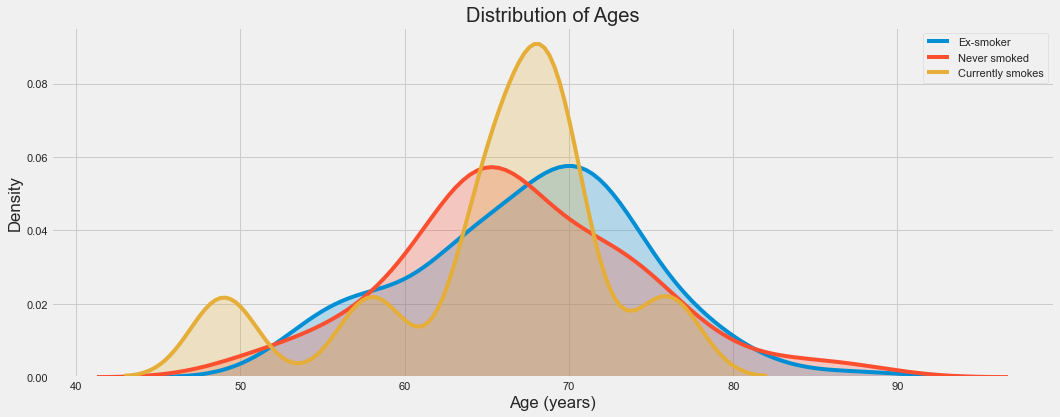

In [25]:
plt.figure(figsize=(16, 6))
sns.kdeplot(patient_df.loc[patient_df['SmokingStatus'] == 'Ex-smoker', 'Age'], label = 'Ex-smoker',shade=True)
sns.kdeplot(patient_df.loc[patient_df['SmokingStatus'] == 'Never smoked', 'Age'], label = 'Never smoked',shade=True)
sns.kdeplot(patient_df.loc[patient_df['SmokingStatus'] == 'Currently smokes', 'Age'], label = 'Currently smokes', shade=True)

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');


## Distribution of Age vs Gender In Patient Dataframe

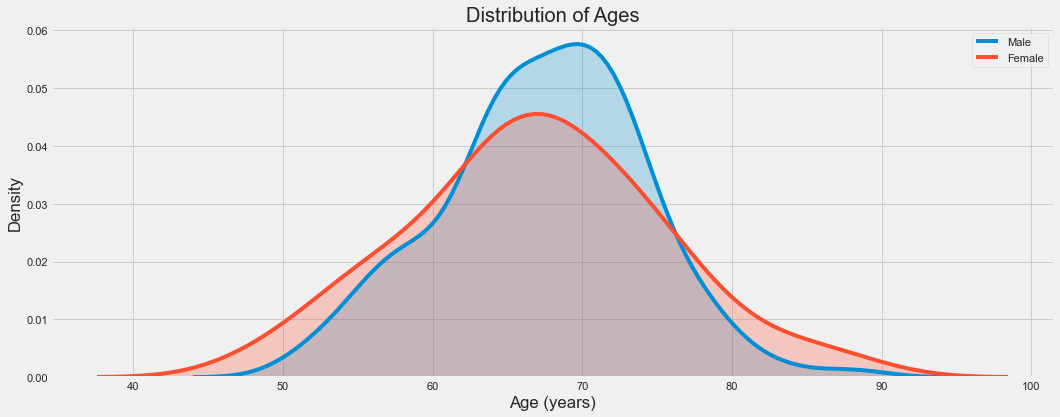

In [26]:
plt.figure(figsize=(16, 6))
sns.kdeplot(patient_df.loc[patient_df['Sex'] == 'Male', 'Age'], label = 'Male',shade=True)
sns.kdeplot(patient_df.loc[patient_df['Sex'] == 'Female', 'Age'], label = 'Female',shade=True)
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

## Gender Distribution


In [27]:
print(patient_df['Sex'].value_counts())

patient_df['Sex'].value_counts().iplot(kind='bar',
                                          yTitle='Count', 
                                          linecolor='black', 
                                          opacity=0.7,
                                          color='blue',
                                          theme='pearl',
                                          bargap=0.8,
                                          gridcolor='white',
                                          title='Distribution of the Sex column in Patient Dataframe')

Male      139
Female     37
Name: Sex, dtype: int64


## Gender vs SmokingStatus In Patient Dataframe

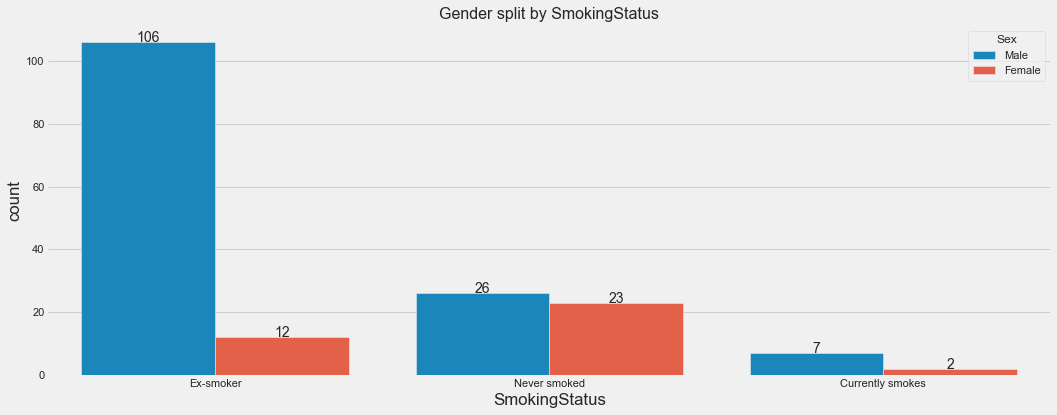

In [28]:
plt.figure(figsize=(16, 6))
a = sns.countplot(data=patient_df, x='SmokingStatus', hue='Sex')

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

plt.title('Gender split by SmokingStatus', fontsize=16)
sns.despine(left=True, bottom=True);

# Patient Overlap


In [29]:
# Extract patient id's for the training set
ids_train = df_train.Patient.values
# Extract patient id's for the validation set
ids_test = df_test.Patient.values
#print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
# Create a "set" datastructure of the training set id's to identify unique id's
ids_train_set = set(ids_train)
print(Fore.YELLOW + "There are",Style.RESET_ALL,f'{len(ids_train_set)}', Fore.BLUE + 'unique Patient IDs',Style.RESET_ALL,'in the training set')
# Create a "set" datastructure of the validation set id's to identify unique id's
ids_test_set = set(ids_test)
print(Fore.YELLOW + "There are", Style.RESET_ALL, f'{len(ids_test_set)}', Fore.BLUE + 'unique Patient IDs',Style.RESET_ALL,'in the test set')

# Identify patient overlap by looking at the intersection between the sets
patient_overlap = list(ids_train_set.intersection(ids_test_set))
n_overlap = len(patient_overlap)
print(Fore.YELLOW + "There are", Style.RESET_ALL, f'{n_overlap}', Fore.BLUE + 'Patient IDs',Style.RESET_ALL, 'in both the training and test sets')
print('')
print(Fore.CYAN + 'These patients are in both the training and test datasets:', Style.RESET_ALL)
print(f'{patient_overlap}')

There are  176 unique Patient IDs  in the training set
There are  5 unique Patient IDs  in the test set
There are  5 Patient IDs  in both the training and test sets

These patients are in both the training and test datasets: 
['ID00421637202311550012437', 'ID00422637202311677017371', 'ID00426637202313170790466', 'ID00423637202312137826377', 'ID00419637202311204720264']


# Visualising Images: DICOM

- **.dcm files:** DICOM files. It's saved in the "Digital Imaging and Communications in Medicine" format. It contains an image from a medical scan, such as an ultrasound or MRI + information about the patient.


In [30]:
print(Fore.YELLOW + 'Train .dcm number of images:',Style.RESET_ALL, len(list(os.listdir('../input/osic-pulmonary-fibrosis-progression/train'))), '\n' +
      Fore.BLUE + 'Test .dcm number of images:',Style.RESET_ALL, len(list(os.listdir('../input/osic-pulmonary-fibrosis-progression/test'))), '\n' +
      '--------------------------------', '\n' +
      'There is the same number of images as in train/ test .csv datasets')

Train .dcm number of images:  177 
Test .dcm number of images:  6 
-------------------------------- 
There is the same number of images as in train/ test .csv datasets


In [31]:
def plot_pixel_array(dataset, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.grid(False)
    plt.imshow(dataset.pixel_array, cmap='gray') # cmap=plt.cm.bone)
    plt.show()

../input/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347/16.dcm
Filename.........:  ../input/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347/16.dcm

Patient's name......:  ID00296637202279895784347, 
Patient id..........:  ID00296637202279895784347
Patient's Sex.......:  
Modality............:  CT
Body Part Examined..:  Chest
Image size.......:   512 x 512, 524288 bytes
Pixel spacing....:  [0.714844, 0.714844]


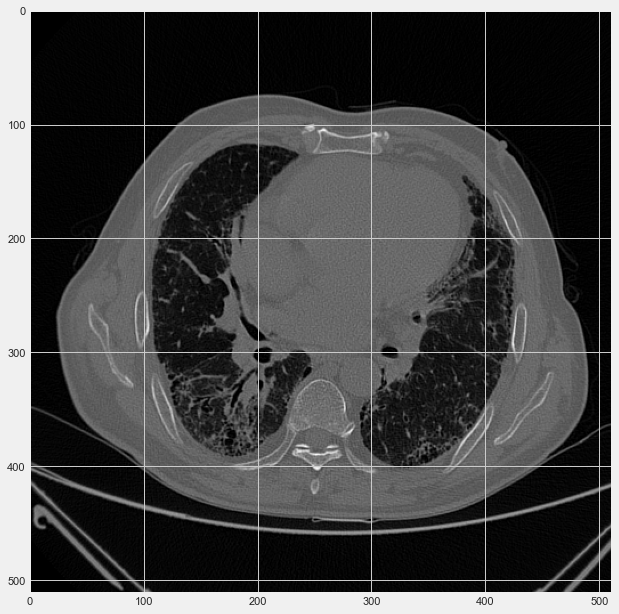

In [32]:
def show_dcm_info(dataset):
    print(Fore.YELLOW + "Filename.........:",Style.RESET_ALL,file_path)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print(Fore.BLUE + "Patient's name......:",Style.RESET_ALL, display_name)
    print(Fore.BLUE + "Patient id..........:",Style.RESET_ALL, dataset.PatientID)
    print(Fore.BLUE + "Patient's Sex.......:",Style.RESET_ALL, dataset.PatientSex)
    print(Fore.YELLOW + "Modality............:",Style.RESET_ALL, dataset.Modality)
    print(Fore.GREEN + "Body Part Examined..:",Style.RESET_ALL, dataset.BodyPartExamined)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print(Fore.BLUE + "Image size.......:",Style.RESET_ALL," {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print(Fore.YELLOW + "Pixel spacing....:",Style.RESET_ALL,dataset.PixelSpacing)
            dataset.PixelSpacing = [1, 1]
        plt.figure(figsize=(10, 10))
        plt.imshow(dataset.pixel_array, cmap='gray')
        plt.show()
for file_path in glob.glob('../input/osic-pulmonary-fibrosis-progression/train/*/*.dcm'):
    print(file_path)
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    break # Comment this out to see all

In [33]:
dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.12779743606216391659179055517331126608
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']
(0008, 0018) SOP Instance UID                    UI: 2.25.12779743606216391659179055517331126608
(0008, 0060) Modality                            CS: 'CT'
(000

total images for patient ID00123637202217151272140:  258


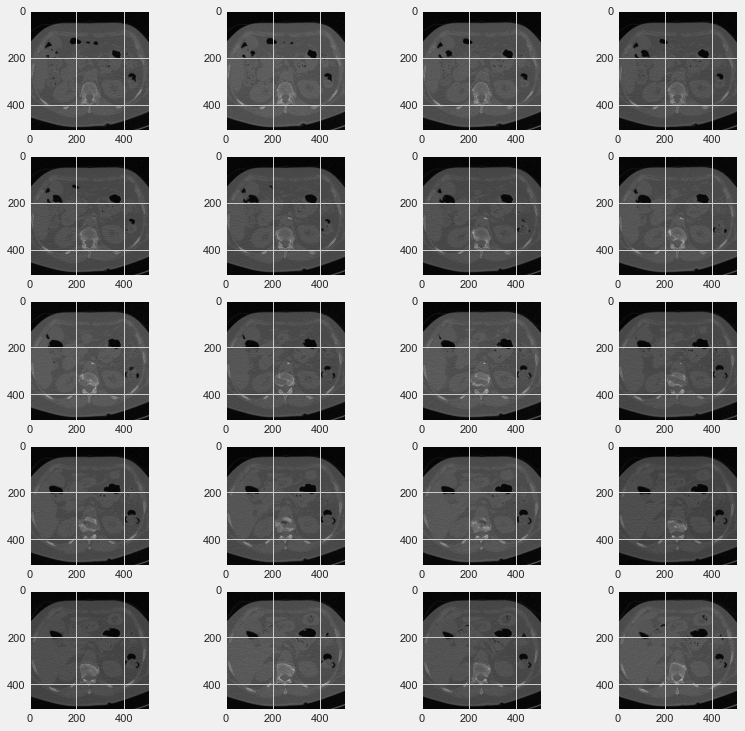

In [34]:
imdir = "../input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140"
print("total images for patient ID00123637202217151272140: ", len(os.listdir(imdir)))

# view first (columns*rows) images in order
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
imglist = os.listdir(imdir)
for i in range(1, columns*rows +1):
    filename = imdir + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='gray')
plt.show()

total images for patient ID00123637202217151272140:  258


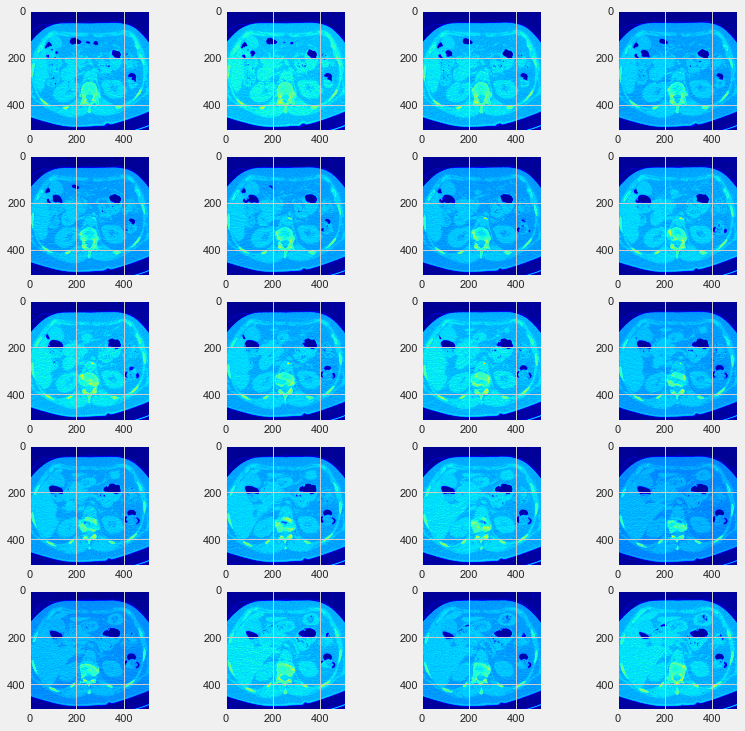

In [35]:
imdir = "../input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140"
print("total images for patient ID00123637202217151272140: ", len(os.listdir(imdir)))

# view first (columns*rows) images in order
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
imglist = os.listdir(imdir)
for i in range(1, columns*rows +1):
    filename = imdir + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='jet')
plt.show()

# Extract Dicom Meta data

In [36]:
def extract_dicom_meta_data(filename: str) -> Dict:
    # Load image
    
    image_data = pydicom.read_file(filename)
    img=np.array(image_data.pixel_array).flatten()
    row = {
        'Patient': image_data.PatientID,
        'body_part_examined': image_data.BodyPartExamined,
        'image_position_patient': image_data.ImagePositionPatient,
        'image_orientation_patient': image_data.ImageOrientationPatient,
        'photometric_interpretation': image_data.PhotometricInterpretation,
        'rows': image_data.Rows,
        'columns': image_data.Columns,
        'pixel_spacing': image_data.PixelSpacing,
        'window_center': image_data.WindowCenter,
        'window_width': image_data.WindowWidth,
        'modality': image_data.Modality,
        'StudyInstanceUID': image_data.StudyInstanceUID,
        'SeriesInstanceUID': image_data.StudyInstanceUID,
        'StudyID': image_data.StudyInstanceUID, 
        'SamplesPerPixel': image_data.SamplesPerPixel,
        'BitsAllocated': image_data.BitsAllocated,
        'BitsStored': image_data.BitsStored,
        'HighBit': image_data.HighBit,
        'PixelRepresentation': image_data.PixelRepresentation,
        'RescaleIntercept': image_data.RescaleIntercept,
        'RescaleSlope': image_data.RescaleSlope,
        'img_min': np.min(img),
        'img_max': np.max(img),
        'img_mean': np.mean(img),
        'img_std': np.std(img)}

    return row

train_image_path = '../input/osic-pulmonary-fibrosis-progression/train'
train_image_files = glob.glob(os.path.join(train_image_path, '*', '*.dcm'))

meta_data_df = []
for filename in tqdm.tqdm(train_image_files):
    try:
        meta_data_df.append(extract_dicom_meta_data(filename))
    except Exception as e:
        continue

100%|██████████| 33026/33026 [04:12<00:00, 130.55it/s]


In [37]:
# Convert to a pd.DataFrame from dict
meta_data_df = pd.DataFrame.from_dict(meta_data_df)
print(meta_data_df.shape)
print(meta_data_df.columns)
meta_data_df.head()


(32538, 25)
Index(['Patient', 'body_part_examined', 'image_position_patient',
       'image_orientation_patient', 'photometric_interpretation', 'rows',
       'columns', 'pixel_spacing', 'window_center', 'window_width', 'modality',
       'StudyInstanceUID', 'SeriesInstanceUID', 'StudyID', 'SamplesPerPixel',
       'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation',
       'RescaleIntercept', 'RescaleSlope', 'img_min', 'img_max', 'img_mean',
       'img_std'],
      dtype='object')


Patient body_part_examined    image_position_patient  \
0  ID00296637202279895784347              Chest  [-198, -35, -491.099976]   
1  ID00296637202279895784347              Chest  [-198, -35, -501.099976]   
2  ID00296637202279895784347              Chest  [-198, -35, -481.099976]   
3  ID00296637202279895784347              Chest  [-198, -35, -621.099976]   
4  ID00296637202279895784347              Chest  [-198, -35, -611.099976]   

  image_orientation_patient photometric_interpretation  rows  columns  \
0        [1, 0, 0, 0, 1, 0]                MONOCHROME2   512      512   
1        [1, 0, 0, 0, 1, 0]                MONOCHROME2   512      512   
2        [1, 0, 0, 0, 1, 0]                MONOCHROME2   512      512   
3        [1, 0, 0, 0, 1, 0]                MONOCHROME2   512      512   
4        [1, 0, 0, 0, 1, 0]                MONOCHROME2   512      512   

          pixel_spacing  window_center  window_width  ... BitsAllocated  \
0  [0.714844, 0.714844]         -500.0       -1500.0  ...            16   
1  [0.714844, 0.714844]         -500.0       -1500.0  ...            16   
2  [0.714844, 0.714844]         -500.0       -1500.0  ...            16   
3  [0.714844, 0.714844]         -500.0       -1500.0  ...            16   
4  [0.714844, 0.714844]         -500.0       -1500.0  ...            16   

  BitsStored HighBit PixelRepresentation  RescaleIntercept  RescaleSlope  \
0         16      15                   1               0.0           1.0   
1         16      15                   1               0.0           1.0   
2         16      15                   1               0.0           1.0   
3         16      15                   1               0.0           1.0   
4         16      15                   1               0.0           1.0   

   img_min  img_max    img_mean     img_std  
0    -1024     1600 -532.366531  484.292470  
1    -1024     1635 -534.258228  489.548827  
2    -1024     1646 -530.787209  487.742244  
3    -1024     1583 -478.588120  499.389977  
4    -1024     1553 -468.104801  501.146437  

[5 rows x 25 columns]

# Extract Dicom Attributes

In [38]:
folder='train'
PATH='../input/osic-pulmonary-fibrosis-progression/'

last_index = 2

column_names = ['image_name', 'dcm_ImageOrientationPatient', 
                'dcm_ImagePositionPatient', 'dcm_PatientID',
                'dcm_PatientName', 'dcm_PatientSex'
                'dcm_rows', 'dcm_columns']

def extract_DICOM_attributes(folder):
    patients_folder = list(os.listdir(os.path.join(PATH, folder)))
    df = pd.DataFrame()
    
    i = 0
    
    for patient_id in patients_folder:
   
        img_path = os.path.join(PATH, folder, patient_id)
        
        print(img_path)
        
        images = list(os.listdir(img_path))
        
        #df = pd.DataFrame()

        for image in images:
            image_name = image.split(".")[0]

            dicom_file_path = os.path.join(img_path,image)
            dicom_file_dataset = pydicom.read_file(dicom_file_path)
                
            '''
            print(dicom_file_dataset.dir("pat"))
            print(dicom_file_dataset.data_element("ImageOrientationPatient"))
            print(dicom_file_dataset.data_element("ImagePositionPatient"))
            print(dicom_file_dataset.data_element("PatientID"))
            print(dicom_file_dataset.data_element("PatientName"))
            print(dicom_file_dataset.data_element("PatientSex"))
            '''
            
            imageOrientationPatient = dicom_file_dataset.ImageOrientationPatient
            #imagePositionPatient = dicom_file_dataset.ImagePositionPatient
            patientID = dicom_file_dataset.PatientID
            patientName = dicom_file_dataset.PatientName
            patientSex = dicom_file_dataset.PatientSex
        
            rows = dicom_file_dataset.Rows
            cols = dicom_file_dataset.Columns
            
            #print(rows)
            #print(columns)
            
            temp_dict = {'image_name': image_name, 
                                    'dcm_ImageOrientationPatient': imageOrientationPatient,
                                    #'dcm_ImagePositionPatient':imagePositionPatient,
                                    'dcm_PatientID': patientID, 
                                    'dcm_PatientName': patientName,
                                    'dcm_PatientSex': patientSex,
                                    'dcm_rows': rows,
                                    'dcm_columns': cols}


            df = df.append([temp_dict])
            
        i += 1
        
        if i == last_index:
            break
            
    return df

extract_DICOM_attributes('train')

../input/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347
../input/osic-pulmonary-fibrosis-progression/train/ID00032637202181710233084


image_name dcm_ImageOrientationPatient              dcm_PatientID  \
0          16          [1, 0, 0, 0, 1, 0]  ID00296637202279895784347   
0          17          [1, 0, 0, 0, 1, 0]  ID00296637202279895784347   
0          15          [1, 0, 0, 0, 1, 0]  ID00296637202279895784347   
0          29          [1, 0, 0, 0, 1, 0]  ID00296637202279895784347   
0          28          [1, 0, 0, 0, 1, 0]  ID00296637202279895784347   
..        ...                         ...                        ...   
0         133          [1, 0, 0, 0, 1, 0]  ID00032637202181710233084   
0         132          [1, 0, 0, 0, 1, 0]  ID00032637202181710233084   
0         126          [1, 0, 0, 0, 1, 0]  ID00032637202181710233084   
0          33          [1, 0, 0, 0, 1, 0]  ID00032637202181710233084   
0          27          [1, 0, 0, 0, 1, 0]  ID00032637202181710233084   

              dcm_PatientName dcm_PatientSex  dcm_rows  dcm_columns  
0   ID00296637202279895784347                      512          512  
0   ID00296637202279895784347                      512          512  
0   ID00296637202279895784347                      512          512  
0   ID00296637202279895784347                      512          512  
0   ID00296637202279895784347                      512          512  
..                        ...            ...       ...          ...  
0   ID00032637202181710233084                      512          512  
0   ID00032637202181710233084                      512          512  
0   ID00032637202181710233084                      512          512  
0   ID00032637202181710233084                      512          512  
0   ID00032637202181710233084                      512          512  

[236 rows x 7 columns]

# Pandas Profiling

In [39]:
import pandas_profiling as pdp
train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

In [40]:
profile_train_df = pdp.ProfileReport(train_df)

In [41]:
profile_train_df

In [42]:
meta_data_df

Patient body_part_examined  \
0      ID00296637202279895784347              Chest   
1      ID00296637202279895784347              Chest   
2      ID00296637202279895784347              Chest   
3      ID00296637202279895784347              Chest   
4      ID00296637202279895784347              Chest   
...                          ...                ...   
32533  ID00108637202209619669361              Chest   
32534  ID00108637202209619669361              Chest   
32535  ID00108637202209619669361              Chest   
32536  ID00108637202209619669361              Chest   
32537  ID00108637202209619669361              Chest   

                      image_position_patient  \
0                   [-198, -35, -491.099976]   
1                   [-198, -35, -501.099976]   
2                   [-198, -35, -481.099976]   
3                   [-198, -35, -621.099976]   
4                   [-198, -35, -611.099976]   
...                                      ...   
32533   [184.100006, 180.000000, -42.500000]   
32534  [184.100006, 180.000000, -260.625000]   
32535  [184.100006, 180.000000, -264.375000]   
32536  [184.100006, 180.000000, -322.500000]   
32537  [184.100006, 180.000000, -326.250000]   

                               image_orientation_patient  \
0                                     [1, 0, 0, 0, 1, 0]   
1                                     [1, 0, 0, 0, 1, 0]   
2                                     [1, 0, 0, 0, 1, 0]   
3                                     [1, 0, 0, 0, 1, 0]   
4                                     [1, 0, 0, 0, 1, 0]   
...                                                  ...   
32533  [-1.000000, 0.000000, 0.000000, 0.000000, -1.0...   
32534  [-1.000000, 0.000000, 0.000000, 0.000000, -1.0...   
32535  [-1.000000, 0.000000, 0.000000, 0.000000, -1.0...   
32536  [-1.000000, 0.000000, 0.000000, 0.000000, -1.0...   
32537  [-1.000000, 0.000000, 0.000000, 0.000000, -1.0...   

      photometric_interpretation  rows  columns         pixel_spacing  \
0                    MONOCHROME2   512      512  [0.714844, 0.714844]   
1                    MONOCHROME2   512      512  [0.714844, 0.714844]   
2                    MONOCHROME2   512      512  [0.714844, 0.714844]   
3                    MONOCHROME2   512      512  [0.714844, 0.714844]   
4                    MONOCHROME2   512      512  [0.714844, 0.714844]   
...                          ...   ...      ...                   ...   
32533                MONOCHROME2   768      768  [0.468750, 0.468750]   
32534                MONOCHROME2   768      768  [0.468750, 0.468750]   
32535                MONOCHROME2   768      768  [0.468750, 0.468750]   
32536                MONOCHROME2   768      768  [0.468750, 0.468750]   
32537                MONOCHROME2   768      768  [0.468750, 0.468750]   

       window_center  window_width  ... BitsAllocated BitsStored HighBit  \
0             -500.0       -1500.0  ...            16         16      15   
1             -500.0       -1500.0  ...            16         16      15   
2             -500.0       -1500.0  ...            16         16      15   
3             -500.0       -1500.0  ...            16         16      15   
4             -500.0       -1500.0  ...            16         16      15   
...              ...           ...  ...           ...        ...     ...   
32533         -500.0       -1500.0  ...            16         16      15   
32534         -500.0       -1500.0  ...            16         16      15   
32535         -500.0       -1500.0  ...            16         16      15   
32536         -500.0       -1500.0  ...            16         16      15   
32537         -500.0       -1500.0  ...            16         16      15   

      PixelRepresentation  RescaleIntercept  RescaleSlope  img_min  img_max  \
0                       1               0.0           1.0    -1024     1600   
1                       1               0.0           1.0    -1024     1635   
2                       1              

In [43]:
meta_data_df.isnull().sum()

Patient                       0
body_part_examined            0
image_position_patient        0
image_orientation_patient     0
photometric_interpretation    0
rows                          0
columns                       0
pixel_spacing                 0
window_center                 0
window_width                  0
modality                      0
StudyInstanceUID              0
SeriesInstanceUID             0
StudyID                       0
SamplesPerPixel               0
BitsAllocated                 0
BitsStored                    0
HighBit                       0
PixelRepresentation           0
RescaleIntercept              0
RescaleSlope                  0
img_min                       0
img_max                       0
img_mean                      0
img_std                       0
dtype: int64

# playground

In [44]:
def get_observation_data(path):
    """Get information from the .dcm files.
    path: complete path to the .dcm file"""

    image_data = pydicom.read_file(path)
    
    # Dictionary to store the information from the image
    observation_data = {
        "FileNumber" : path.split("/")[5],
        "Rows" : image_data.get("Rows"),
        "Columns" : image_data.get("Columns"),
        "PatientID" : image_data.get("PatientID"),
        "BodyPartExamined" : image_data.get("BodyPartExamined"),
        "RotationDirection" : image_data.get("RotationDirection"),
        "ConvolutionKernel" : image_data.get("ConvolutionKernel"),
        "PatientPosition" : image_data.get("PatientPosition"),
        "PhotometricInterpretation" : image_data.get("PhotometricInterpretation"),
        "Modality" : image_data.get("Modality"),
        "StudyInstanceUID" : image_data.get("StudyInstanceUID"),
        "PixelPaddingValue" : image_data.get("PixelPaddingValue"),
        "SamplesPerPixel" : image_data.get("SamplesPerPixel"),
        "BitsAllocated" : image_data.get("BitsAllocated"),
        "BitsStored" : image_data.get("BitsStored"),
        "HighBit" : image_data.get("HighBit"),
        "PixelRepresentation" : image_data.get("PixelRepresentation"),
        "RescaleType" : image_data.get("RescaleType"),
    }

    # Integer columns
    int_columns = ["SliceThickness", "KVP", "DistanceSourceToDetector", 
        "DistanceSourceToPatient", "GantryDetectorTilt", "TableHeight", 
        "XRayTubeCurrent", "GeneratorPower", "WindowCenter", "WindowWidth", 
        "SliceLocation", "RescaleIntercept", "RescaleSlope"]
    for k in int_columns:
        observation_data[k] = int(image_data.get(k)) if k in image_data else None

    # String columns
    str_columns = ["ImagePositionPatient", "ImageOrientationPatient", "ImageType", "PixelSpacing"]
    for k in str_columns:
        observation_data[k] = str(image_data.get(k)) if k in image_data else None

    
    return observation_data

In [45]:
p = "../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/10.dcm"
example = get_observation_data(p)

In [46]:
example

{'FileNumber': '10.dcm',
 'Rows': 512,
 'Columns': 512,
 'PatientID': 'ID00007637202177411956430',
 'BodyPartExamined': 'Chest',
 'RotationDirection': 'CW',
 'ConvolutionKernel': 'BONE',
 'PatientPosition': 'FFS',
 'PhotometricInterpretation': 'MONOCHROME2',
 'Modality': 'CT',
 'StudyInstanceUID': '2.25.80896671862726099888461805953012988790',
 'PixelPaddingValue': -2000,
 'SamplesPerPixel': 1,
 'BitsAllocated': 16,
 'BitsStored': 16,
 'HighBit': 15,
 'PixelRepresentation': 1,
 'RescaleType': 'HU',
 'SliceThickness': 1,
 'KVP': 120,
 'DistanceSourceToDetector': 949,
 'DistanceSourceToPatient': 541,
 'GantryDetectorTilt': 0,
 'TableHeight': 130,
 'XRayTubeCurrent': 79,
 'GeneratorPower': 9600,
 'WindowCenter': -500,
 'WindowWidth': -1500,
 'SliceLocation': -159,
 'RescaleIntercept': -1024,
 'RescaleSlope': 1,
 'ImagePositionPatient': '[-158.700, -153.500, -159.750]',
 'ImageOrientationPatient': '[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]',
 'ImageType': "['ORIGINAL', '

In [48]:
train = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/train.csv")
# Create base director for Train .dcm files
director = "../input/osic-pulmonary-fibrosis-progression/train"

# Create path column with the path to each patient's CT
train["Path"] = director + "/" + train["Patient"]

# Create variable that shows how many CT scans each patient has
train["CT_number"] = 0

for k, path in enumerate(train["Path"]):
    train["CT_number"][k] = len(os.listdir(path))

In [49]:
# Get full paths for the images
paths = []
for path in train["Path"]:
    for doc in os.listdir(path):
        paths.append(path + "/" + doc)
        
# How many paths?
print("There are {:,} paths in total.".format(len(paths)))


There are 289,826 paths in total.


In [53]:
len(np.unique(paths))

33026

In [58]:
train_image_files[0].split("/")[-1]

'16.dcm'